In [1]:
from lxml import etree
import requests
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import mpl_toolkits.basemap.pyproj as pyproj
import fiona
from itertools import chain
%matplotlib inline

* this notebook is adapted from Sensitive Cities Python Map [blog post](http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.V5ZRAZMrKqD)

In [2]:
# select plot font
fm.findSystemFonts(fontpaths='C:\\Windows\\Fonts\\', fontext='ttf')
prop = fm.FontProperties(fname='C:\\Windows\\Fonts\\calibrii.ttf')

In [3]:
# docs say use top-left and bottom right - this is ury, llx, urx, lly
#r = requests.get(
#    "http://openplaques.org/plaques.json?box=[%s, %s],[%s, %s]&limit=2500" % 
#    (ur[1], ll[0], ur[0], ll[1]))

# Parse an XML file into a dict

In [4]:
# parse XML into dict
tree = etree.parse("../data/london_20131229.xml")
root = tree.getroot()

output = dict()
output['raw'] = []
output['crs'] = []
output['lon'] = []
output['lat'] = []

for each in root.xpath('/openplaques/plaque/geo'):
    # check what we got back
    output['crs'].append(each.get('reference_system', None))
    output['lon'].append(each.get('longitude', None))
    output['lat'].append(each.get('latitude', None))
    # now go back up to plaque
    r = each.getparent().xpath('inscription/raw')[0]
    if isinstance(r.text, str):
        output['raw'].append(r.text.lstrip().rstrip())
    else:
        output['raw'].append(None)

# Set up a DataFrame, and perform type conversion(s)

In [5]:
df = pd.DataFrame(output)
df = df.replace({'raw': 0}, None)
df = df.dropna()
df[['lon', 'lat']] = df[['lon', 'lat']].astype(float)
df.head()

,crs,lat,lon,raw
0,WGS84,51.47360,-0.00149,Ignatius Sancho c1729-1780. African man of let...
1,WGS84,51.47365,-0.00127,A bath beneath the paving and this wall are al...
2,WGS84,51.47699,0.01442,In memory of Michael Joseph the Smith and Thom...
3,WGS84,51.50085,-0.13046,A building of historic significance Wililam & ...
4,WGS84,51.49737,-0.12943,Westminster Public Baths and Wash-Houses. The ...


# Get shapefile data, and create bounds, width and height

In [6]:
shp = fiona.open('../data/london_gis/london_wards.shp')
crs_data = shp.crs
bds = shp.bounds
shp.close()
extra = 0.01
# bounds need to be datum-shifted
wgs84 = pyproj.Proj("+init=EPSG:4326")
osgb36 = pyproj.Proj("+init=EPSG:27700")
ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

# Create a Basemap instance, and open the shapefile

(649,
 5,
 [-0.5103750689005356, 51.28676016315085, 0.0, 0.0],
 [0.3340155643740321, 51.691874116909894, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0xd1cfd68>)

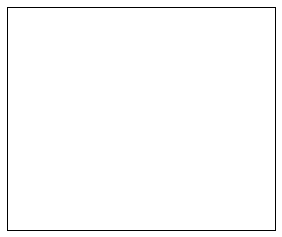

In [7]:
m = Basemap(
    projection='tmerc',
    lon_0 = -2.,
    lat_0 = 49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    '../data/london_gis/london_wards',
    'london',
    color='none',
    zorder=2)

# Create a DataFrame holding ward polygons and area

In [8]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.london],
    'ward_name': [w['NAME'] for w in m.london_info],
})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['ward_name'] = df_map['ward_name'].str.strip()

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df['lon'], df['lat'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = filter(wards_polygon.contains, plaque_points)

In [9]:
# Convenience functions for working with color ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colourmap, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar


def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    
    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)


# Create a scatter plot using plaque point data

# Calculate plaque density data and bins

In [14]:
type(m)

mpl_toolkits.basemap.Basemap

In [21]:
ldn_points

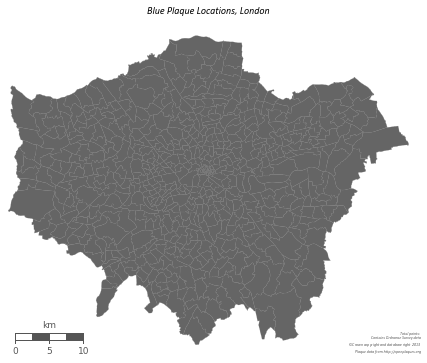

In [19]:
# draw ward patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='#555555', ec='#787878', lw=.25, alpha=.9
    , zorder=4))

plt.clf()
fig = plt.figure()

ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# we don't need to pass points to m() because we calculated using map_points and shapefile polygons
dev = m.scatter(
    [geom.x for geom in ldn_points],
    [geom.y for geom in ldn_points],
    5, marker='o', color = 'k')
    #lw=.25, facecolor='#33ccff', edgecolor='w',
    #alpha=0.9, antialiased=True,
    #label='Blue Plaque Locations',zorder=3)
# plot boroughs by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
# copyright and source data info
smallprint = ax.text(
    1.03, 0,
    'Total points: \nContains Ordnance Survey data\n$\copyright$ Crown copyright and database right 2013\nPlaque data from http://openplaques.org' ,
    ha='right', va='bottom',
    size=4,
    color='#555555',
    transform=ax.transAxes,
    fontproperties=prop,
)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5
)
plt.title("Blue Plaque Locations, London", fontproperties=prop)
plt.tight_layout()
fig.set_size_inches(8.47, 5.25)
plt.savefig('../figures/london_plaques.png', dpi=300, alpha=True)
plt.show()

In [22]:
# create a MultiPoint which we can check for set membership

df_map['count'] = df_map['poly'].map(lambda x: int(len(filter(prep(x).contains, ldn_points))))
df_map['density_m'] = df_map['count'] / df_map['area_m']
df_map['density_km'] = df_map['count'] / df_map['area_km']
# it's easier to work with NaN values when classifying
df_map.replace(to_replace={'density_m': {0: np.nan}, 'density_km': {0: np.nan}}, inplace=True)

TypeError: object of type 'filter' has no len()

### If we want to show intervals, as opposed to levels

`bins` includes the *lowest quantiled value*, so it's `categorical.levels` + 1 in length, whereas `categorical.levels` returns intervals

Since we probably don't care about the lowest value, we can remove it from our labels.

If we wanted to label our colour bar with intervals, we'd use `categorical.levels`
```python
categorical, bins = pd.qcut(df_map['density'], 5, retbins=True)
display = []
for k in categorical.levels:
    ivl = k.split(',')
    display.append([float(ivl[0][1:]), float(ivl[1][:-1])])
display = sorted(["%0.8f - %0.8f/$ft^2$" % (hi, lo) for hi, lo in display])
display.insert(0, "No Sensors")
labels = display
```

In [ ]:
# Calculate quantiles for density
categorical, bins = pd.qcut(df_map['density_km'], 5, retbins=True)
df_map['quantile_bins'] = categorical

In [ ]:
# Calculate Jenks natural breaks for density
breaks = nb(
    df_map[df_map['density_km'].notnull()].density_km.values,
    initial=300,
    k=5)
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['density_km'].notnull()].index)
df_map = df_map.join(jb)
df_map.jenks_bins.fillna(-1, inplace=True)

In [ ]:
# Create Jenks and quantile labels
quantile_labels = ["<= %0.2f/$km^2$(%s wards)" % (b, w) for b, w in zip(
    bins[1:],
    [k for k in pd.value_counts(categorical, sort=False)])]
quantile_labels.insert(0, 'No plaques (%s wards)' % len(df_map[df_map['density_km'].isnull()]))
jenks_labels = ["<= %0.1f/km$^2$(%s wards)" % (b, w) for b, w in zip(
    breaks.bins, breaks.counts)]
jenks_labels.insert(0, 'No plaques (%s wards)' % len(df_map[df_map['density_km'].isnull()]))

# Create a choropleth map using normalised (by area) ward densities

In [ ]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
for label in cb.ax.yaxis.get_ticklabels():
    label.set_fontproperties(prop)
cb.ax.tick_params(labelsize=6)

# Show highest densities, in descending order
highest = '\n'.join(value[1] for
    _, value in df_map[(df_map['jenks_bins'] == 4)][:10].sort_index().iterrows())
highest = 'Most Dense Wards:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    -1., 0 - 0.007,
    highest,
    ha='right', va='bottom',
    size=5,
    color='#555555',
    fontproperties=prop
)

# Bin method, copyright and source data info
smallprint = ax.text(
    1.03, 0,
    'Classification method: natural breaks\nContains Ordnance Survey data\n$\
    copyright$ Crown copyright and database right 2013\nPlaque data from http://openplaques.org',
    ha='right', va='bottom',
    size=4,
    color='#555555',
    transform=ax.transAxes,
    fontproperties=prop,
)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5
)
plt.title("Blue Plaque Density By Ward, London", fontproperties=prop)
plt.tight_layout()
fig.set_size_inches(8.47, 5.25)
plt.savefig('../figures/london_plaque_density.png', alpha=True, dpi=300, bbox_inches="tight")
plt.show()

# Create a density map using hex bins

In [ ]:
# draw ward patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='#555555', ec='#787878', lw=.25, alpha=.9, zorder=0))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# plot boroughs by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

df_london = df[
   (df['lon'] >= ll[0]) &
   (df['lon'] <= ur[0]) &
   (df['lat'] >= ll[1]) &
   (df['lat'] <= ur[1])
]

lon_ldn = df_london.lon.values
lat_ldn = df_london.lat.values

# the mincnt argument only shows cells with a value >= 1
# hexbin wants np arrays, not plain lists
hx = m.hexbin(
    np.array([geom.x for geom in ldn_points]),
    np.array([geom.y for geom in ldn_points]),
    gridsize=125,
    bins='log',
    mincnt=1,
    edgecolor='none',
    alpha=1.,
    lw=0.2,
    cmap=plt.get_cmap('Blues'))

# copyright and source data info
smallprint = ax.text(
    1.03, 0,
    'Total points: %s\nContains Ordnance Survey data\n$\copyright$ Crown copyright and database right 2013\nPlaque data from http://openplaques.org' % len(ldn_points),
    ha='right', va='bottom',
    size=4,
    color='#555555',
    transform=ax.transAxes,
    fontproperties=prop,
)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5
)
plt.title("Blue Plaque Density, London", fontproperties=prop)
plt.tight_layout()
fig.set_size_inches(8.47, 5.25)
plt.savefig('../figures/london_plaques_kde.png', dpi=300, alpha=True)
plt.show()